In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import List, Tuple

In [11]:
def load_image(image_path) -> np.ndarray:
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


def load_images_from_dir(dir_path: str) -> List[Tuple[str, np.ndarray]]:
    return [
        (filename, load_image(os.path.join(dir_path, filename)))
        for filename in os.listdir(dir_path)
    ]

In [12]:
def plot_all_images(images):
    fig, axes = plt.subplots(3, 6, figsize=(20, 8))
    for i, (filename, image) in enumerate(images):
        row = i // 6
        col = i % 6
        axes[row, col].axis("off")
        axes[row, col].imshow(image, cmap="gray")
        axes[row, col].set_title(filename, fontsize=9)
    plt.tight_layout()
    plt.show()

In [13]:
NEW_DIM = 1008


def resize_all(images):
    for filename, image in images:
        # Resize the image
        resized_image = cv2.resize(image, (NEW_DIM, NEW_DIM))

        # Save the resized image (overwrite the original)
        cv2.imwrite(os.path.join("resized", filename), resized_image)

In [14]:
def read_qr(image):
    assert image.shape == (1008, 1008), "Image must be 1008x1008 pixels"

    # split the image into 21 columns and 21 rows, each of 48x48 pixels
    rows = np.vsplit(image, 21)
    cells = np.array([np.hsplit(row, 21) for row in rows])

    new_image = np.zeros((21, 21), dtype=np.uint8)
    for i in range(cells.shape[0]):
        for j in range(cells.shape[1]):
            # make all the pixels in the cell either black or white
            _, cell = cv2.threshold(cells[i, j], 127, 255, cv2.THRESH_BINARY)

            # get first quartile of cell
            q1 = np.percentile(cell, 50)

            new_image[i, j] = q1

    new_image = np.where(new_image > 127, 1, 0).astype(np.uint8)

    return new_image

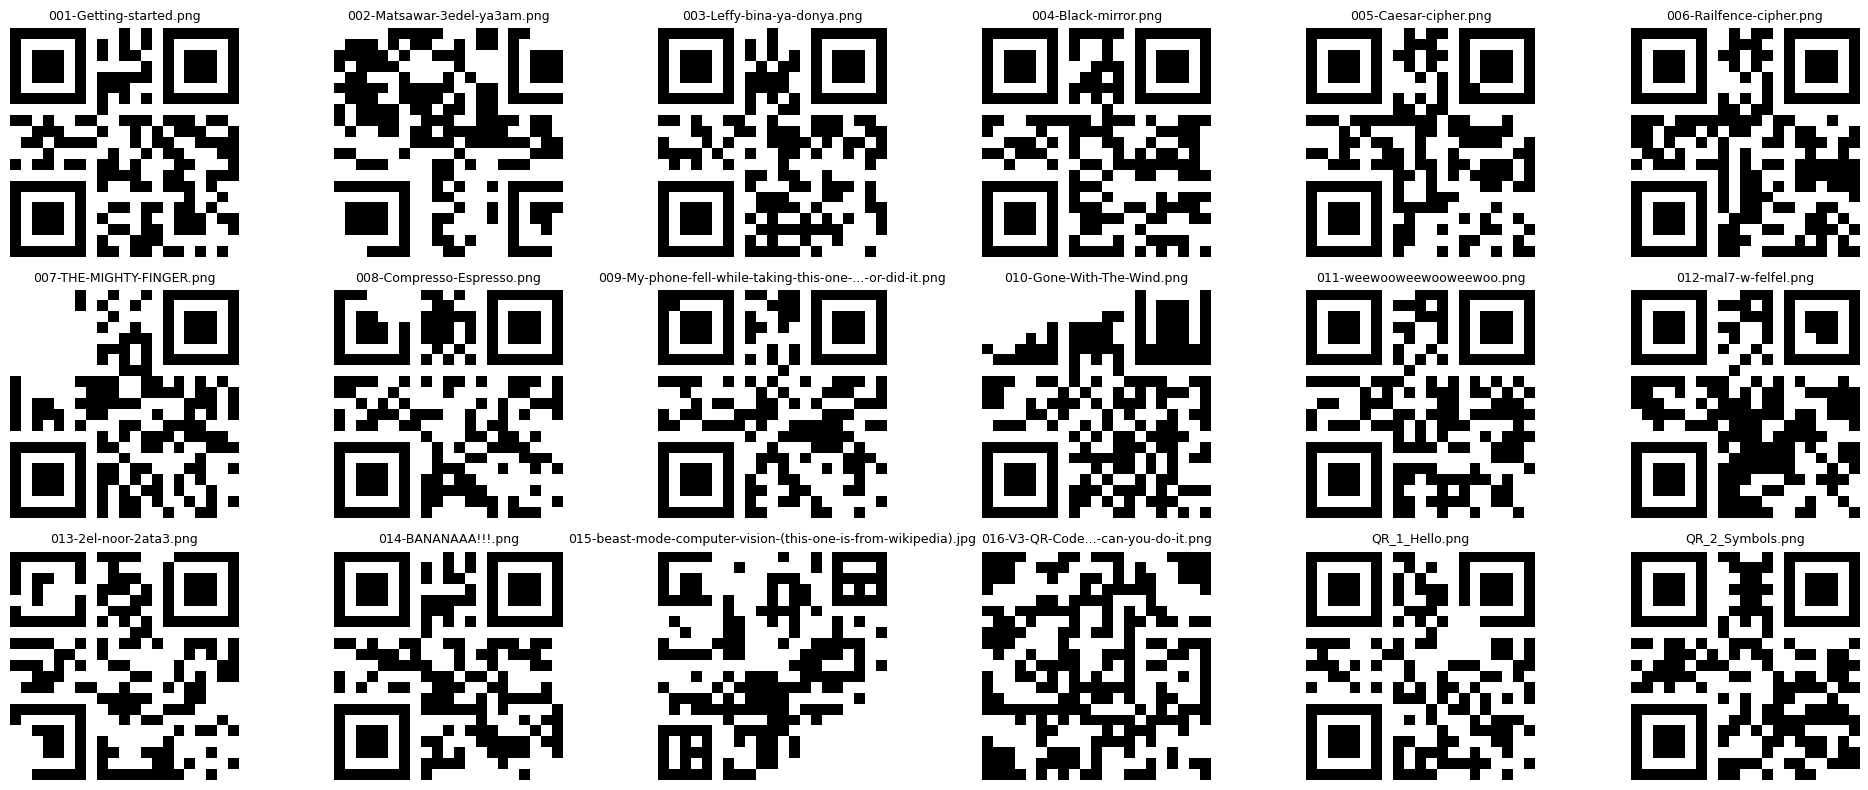

In [15]:
# orig_path = "test_cases"

# perform_pipeline(orig_path, log=False, plot=False)

out_imgs = load_images_from_dir("output_images")

resize_all(out_imgs)

resized_imgs = load_images_from_dir("resized")

read_images = sorted(
    [(filename, read_qr(image)) for filename, image in resized_imgs], key=lambda x: x[0]
)

plot_all_images(read_images)

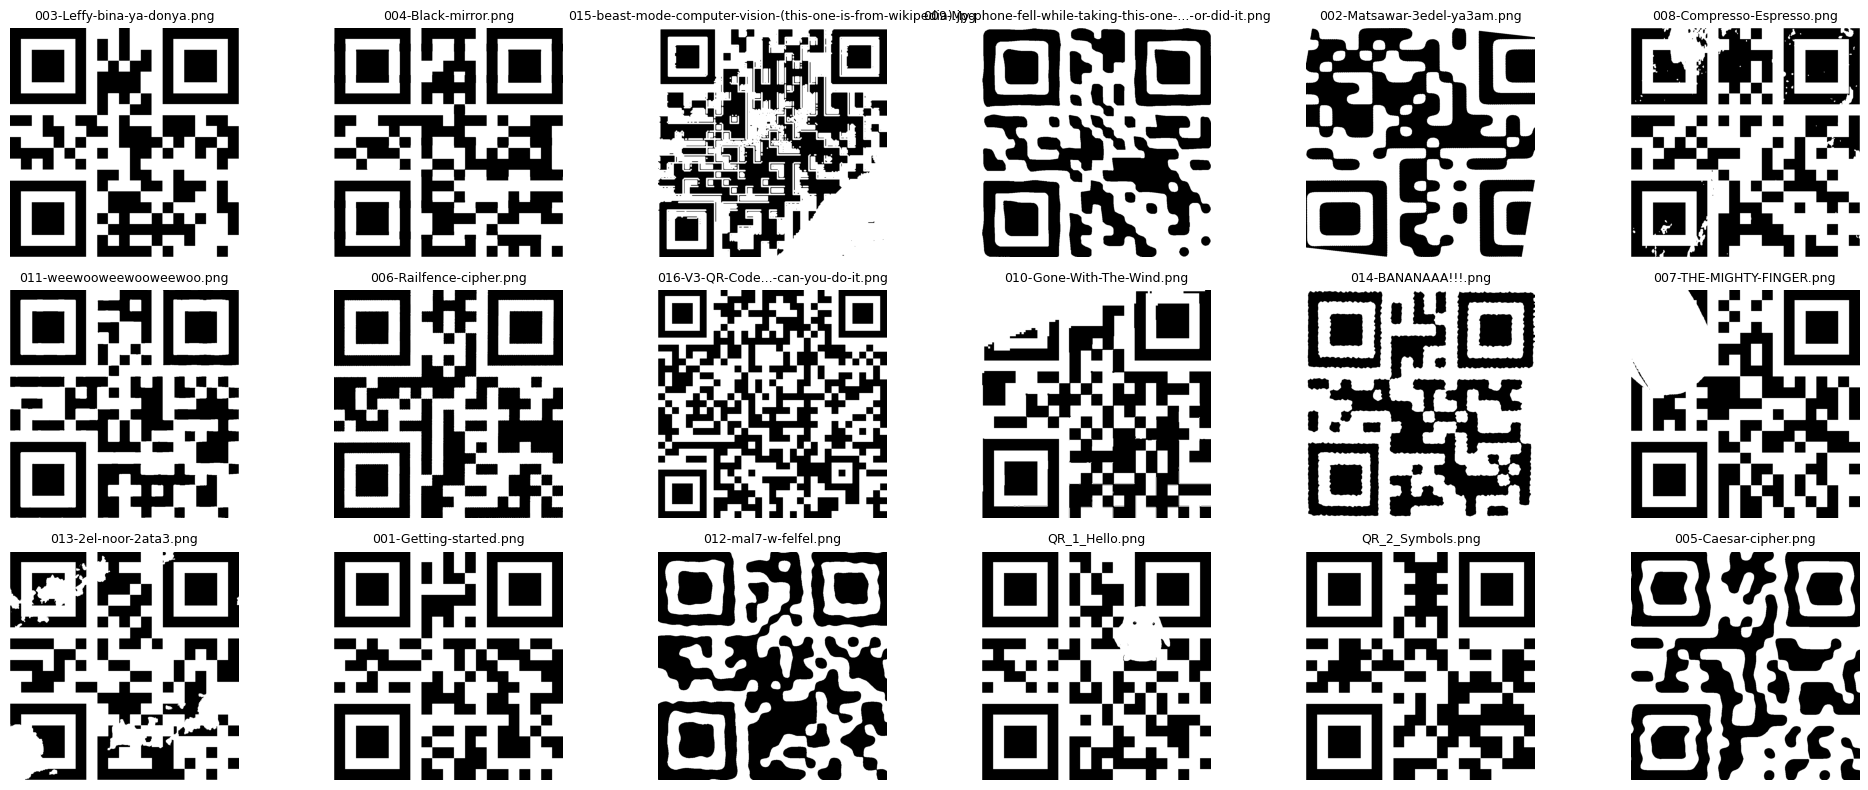

In [16]:
plot_all_images(resized_imgs)

In [17]:
import pickle

pickle.dump(read_images, open("read_images.pkl", "wb"))

In [19]:
# file_path = "test_cases/006-Railfence-cipher.png"
# image = cv2.imread(file_path)

# plt.xlim(0, 1500)
# plt.ylim(1100, -100)

# for coord in coords:
#     cv2.circle(image, (coord[0], coord[1]), 5, (0, 0, 255), -1)
#     cv2.putText(
#         image,
#         f"{coord[0], coord[1]}",
#         (coord[0], coord[1]),
#         cv2.FONT_HERSHEY_SIMPLEX,
#         1,
#         (255, 0, 0),
#         2,
#     )

# plt.imshow(image)

In [20]:
# def warp_transform_image(image, coords):
#     dest_corners = np.array(
#         [[0, 0], [0, NEW_DIM], [NEW_DIM, 0], [NEW_DIM, NEW_DIM]], dtype=np.float32
#     )
#     source_corners = np.array(coords, dtype=np.float32)
#     M = cv2.getPerspectiveTransform(source_corners, dest_corners)
#     return cv2.warpPerspective(image, M, (NEW_DIM, NEW_DIM))


# coords = [(316, 196), (59, 951), (975, 93), (719, 848)]

# file_path = "test_cases/006-Railfence-cipher.png"

# image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# warped_image = warp_transform_image(image, coords)

# plt.imshow(warped_image, cmap="gray")

[ WARN:0@138.012] global loadsave.cpp:248 findDecoder imread_('resized/resized_012-mal7-w-felfel.png'): can't open/read file: check file path/integrity


NameError: name 'new_image' is not defined

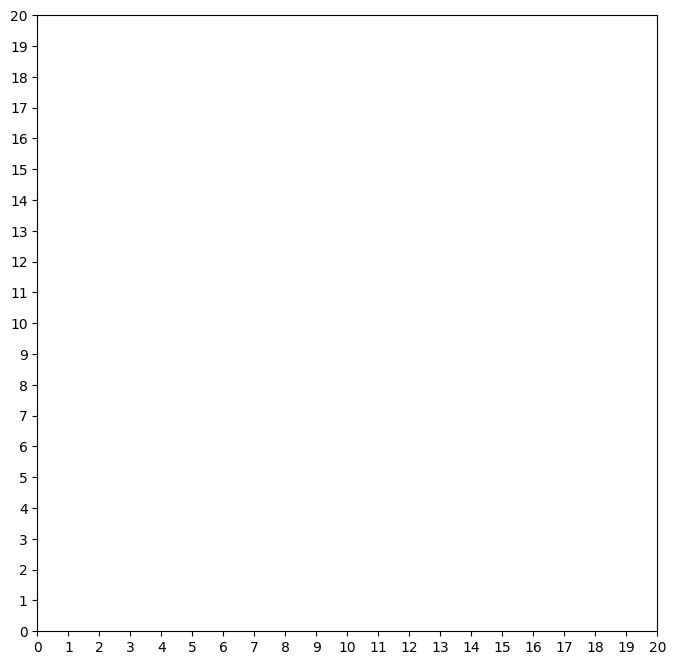

In [21]:
filepath = "resized_012-mal7-w-felfel.png"

img = cv2.imread(f"resized/{filepath}", cv2.IMREAD_GRAYSCALE)


# increase plot size
plt.figure(figsize=(8, 8))

plt.yticks(np.arange(0, 21, 1))
plt.xticks(np.arange(0, 21, 1))
# show values inside each cell
for i in range(21):
    for j in range(21):
        # decrease font size
        plt.text(
            j,
            i,
            new_image[i, j],
            ha="center",
            va="center",
            color="red",
            fontsize=plt.rcParams["figure.figsize"][0],
        )

plt.imshow(new_image, cmap="gray")

plt.show()

In [12]:
# cell.shape

In [24]:
img = cv2.imread(
    "resized/resized_009-My-phone-fell-while-taking-this-one-...-or-did-it.png"
)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to obtain a binary image
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on their area to identify the position boxes
position_boxes = []
for contour in contours:
    area = cv2.contourArea(contour)
    if 100 < area < 1000:  # Adjust the area threshold as needed
        position_boxes.append(contour)

canvas = img.copy()
cv2.drawContours(canvas, position_boxes, -1, (0, 255, 0), 2)
canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

# Plot the image with contours using Matplotlib
plt.imshow(canvas_rgb)
plt.title("Position Boxes")
plt.axis("off")
plt.show()

[ WARN:0@159.399] global loadsave.cpp:248 findDecoder imread_('resized/resized_009-My-phone-fell-while-taking-this-one-...-or-did-it.png'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [23]:
def plot_all_images(images):
    fig, axes = plt.subplots(3, 6, figsize=(20, 8))
    for i, (filename, image) in enumerate(images):
        row = i // 6
        col = i % 6
        axes[row, col].axis("off")
        axes[row, col].imshow(image, cmap="gray")
        axes[row, col].set_title(filename, fontsize=9)
    plt.tight_layout()
    plt.show()

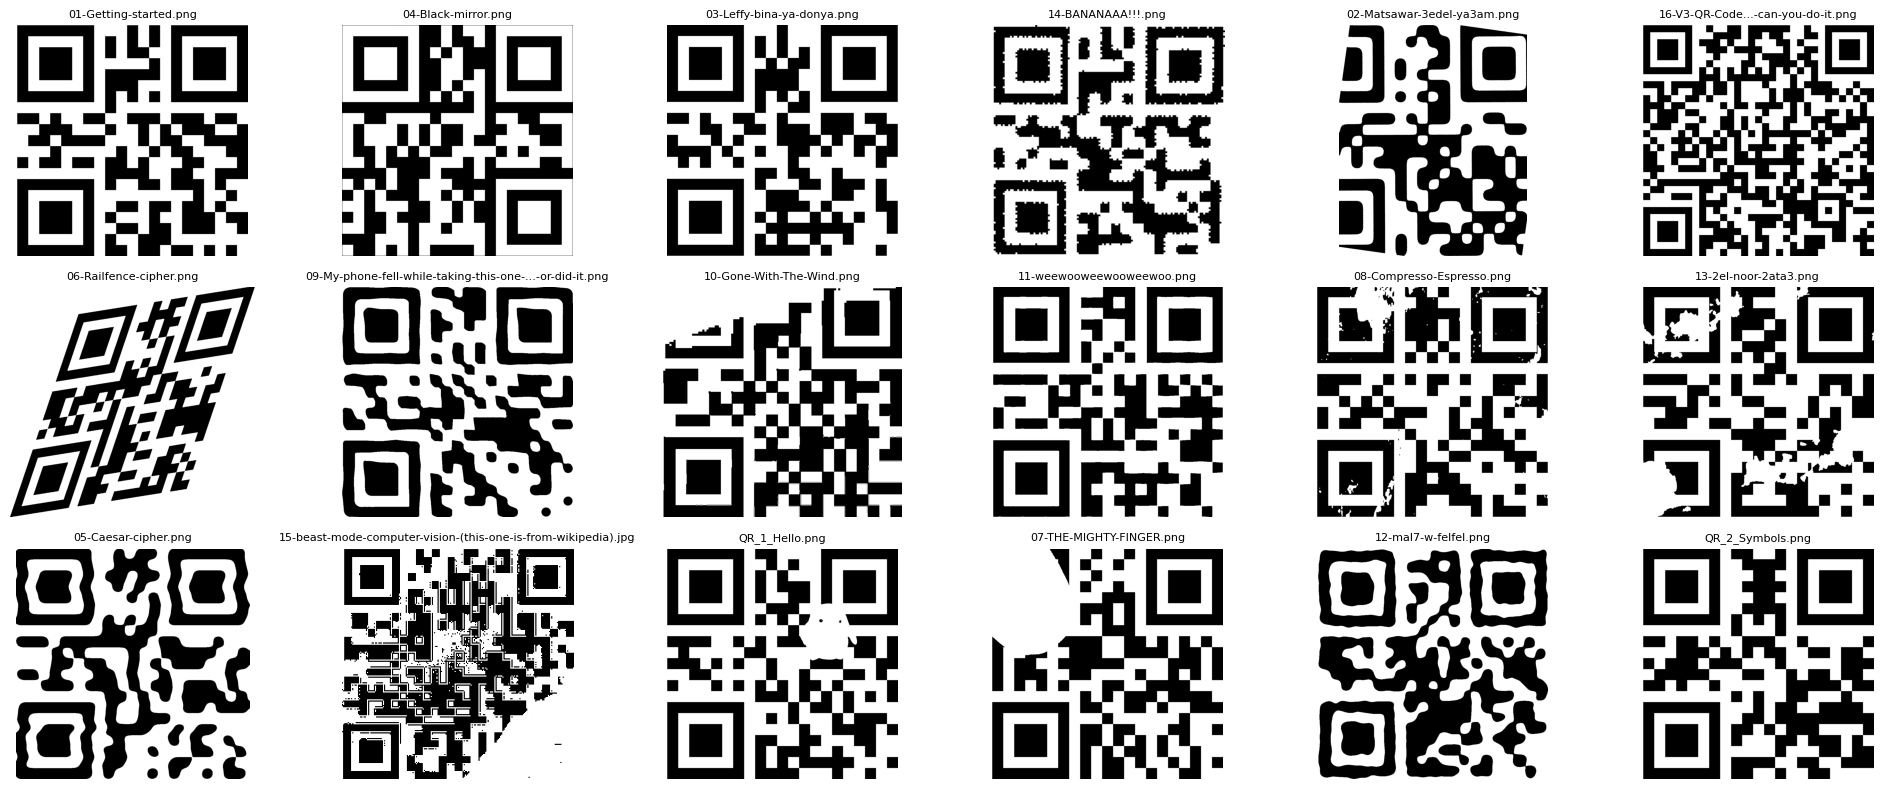

In [ ]:
plot_all_images(images)